# A predictive approach to estimate the maximum voluntary activation of the shoulder muscles

Romain Martinez<sup>*a</sup>, Jonathan Tremblay<sup>a</sup>, Mickael Begon<sup>a</sup>, Fabien Dal Maso<sup>a</sup>

<sup>a</sup>École de kinésiologie et des sciences de l’activité physique, Faculté de Medecine, Université de Montréal, Montréal, Canada

[GitHub repo](https://github.com/romainmartinez/mvc)

# Part 1: Getting the data

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.io as sio

# to make this notebook's output stable across runs
RANDOM_SEED = 34
np.random.seed(RANDOM_SEED)

In [2]:
PROJECT_PATH = Path("./")
DATA_PATH = PROJECT_PATH / "data"
MODEL_PATH = PROJECT_PATH / "model"

## Read the data

We start this notebook with data in matlab format, where each file corresponds to different experiments.

Each file contains a 3-dimensional matrix where the first dimension corresponds to the _participant_, the second to the _tested muscle_ and the third to the _test performed_.

![Maximum voluntary isometric contraction tests performed.](./share/fig/positions.svg)

In [3]:
mat = {}
data = {key: [] for key in ("dataset", "participant", "muscle", "test", "mvc")}
dataset_names = []
count = -1


for ifile in DATA_PATH.glob("*only_max.mat"):
    # dataset name
    dataset = ifile.stem.replace("_only_max", "").replace("MVE_Data_", "")
    dataset_names.append(dataset)

    # data
    mat[dataset] = sio.loadmat(ifile)["MVE"]
    print(f"project {dataset}: {mat[dataset].shape[0]} participants")

    for iparticipant in range(mat[dataset].shape[0]):
        count += 1
        for imuscle in range(mat[dataset].shape[1]):
            for itest in range(mat[dataset].shape[2]):
                data["participant"].append(count)
                data["dataset"].append(dataset)
                data["muscle"].append(imuscle)
                data["test"].append(itest)
                data["mvc"].append(mat[dataset][iparticipant, imuscle, itest])

project Romain2017: 32 participants
project Landry2015_1: 14 participants
project Landry2012: 18 participants
project Yoann_2015: 22 participants
project Tennis: 16 participants
project Violon: 10 participants
project Patrick_2013: 16 participants
project Landry2015_2: 11 participants
project Landry2016: 15 participants
project Sylvain_2015: 10 participants
project Landry2013: 21 participants


## Transform the data

In [4]:
df_tidy = pd.DataFrame(data).dropna()
df_tidy["test"] = df_tidy["test"].apply(lambda x: f"test {str(x + 1).zfill(2)}")

MUSCLES = [
    "upper trapezius",
    "middle trapezius",
    "lower trapezius",
    "anterior deltoid",
    "middle deltoid",
    "posterior deltoid",
    "pectoralis major",
    "serratus anterior",
    "latissimus dorsi",
    "supraspinatus",
    "infraspinatus",
    "subscapularis",
]


df_tidy["muscle"] = np.array(MUSCLES)[df_tidy["muscle"]]

print(f"dataset shape = {df_tidy.shape}")
df_tidy.head()

dataset shape = (18465, 5)


,dataset,participant,muscle,test,mvc
0,Romain2017,0,upper trapezius,test 01,0.000381
3,Romain2017,0,upper trapezius,test 04,0.000300
4,Romain2017,0,upper trapezius,test 05,0.000348
5,Romain2017,0,upper trapezius,test 06,0.000111
8,Romain2017,0,upper trapezius,test 09,0.000249


In [5]:
df_wide = df_tidy.pivot_table(
    index=["dataset", "participant", "muscle"],
    columns="test",
    values="mvc",
    fill_value=np.nan,
).reset_index()
df_wide.head()

test,dataset,participant,muscle,test 01,test 02,test 03,test 04,test 05,test 06,test 07,test 08,test 09,test 10,test 11,test 12,test 13,test 14,test 15,test 16
0,Landry2012,46,anterior deltoid,0.013480,0.060322,0.102243,0.262121,0.216671,0.007603,0.009864,0.030523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Landry2012,46,latissimus dorsi,0.003968,0.077672,0.019619,0.024144,0.021569,0.151734,0.145337,0.060694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Landry2012,46,lower trapezius,0.025092,0.205321,0.300761,0.170296,0.191271,0.070199,0.140505,0.017468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Landry2012,46,middle deltoid,0.028731,0.145174,0.170468,0.085861,0.121181,0.035754,0.009872,0.011396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Landry2012,46,middle trapezius,0.011083,0.135626,0.130890,0.042650,0.062615,0.046499,0.040964,0.016394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Part 2: Data exploration

In [6]:
import altair as alt
from altair import datum
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Muscles and tests count

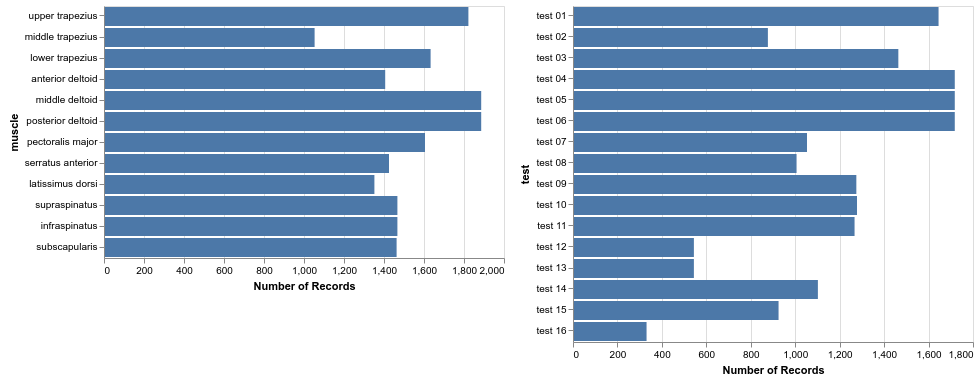

In [7]:
base = alt.Chart(df_tidy).encode(x="count()")
muscle = base.mark_bar().encode(alt.Y("muscle", sort=alt.Sort(MUSCLES)))
test = base.mark_bar().encode(y="test")
muscle | test

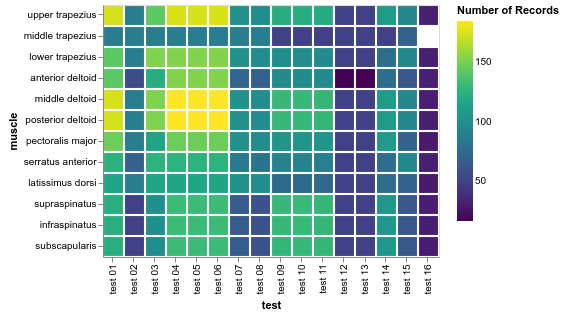

In [8]:
alt.Chart(df_tidy).mark_rect().encode(
    x="test", y=alt.Y("muscle", sort=alt.Sort(MUSCLES)), color="count()"
)

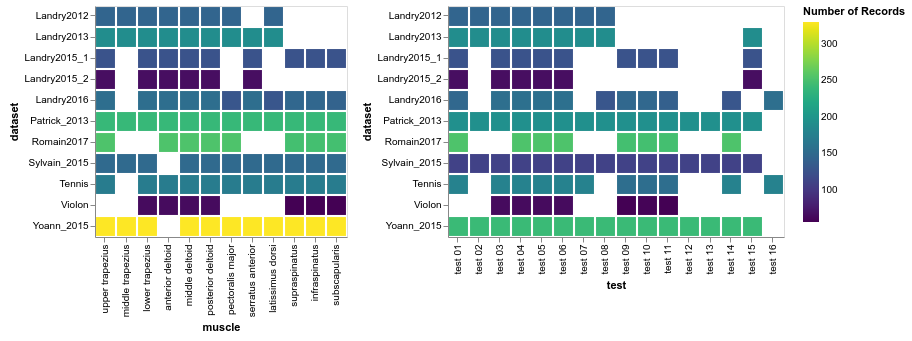

In [9]:
base = alt.Chart(df_tidy).encode(y="dataset", color="count()")
test = base.mark_rect().encode(x="test")
muscle = base.mark_rect().encode(alt.X("muscle", sort=alt.Sort(MUSCLES)))
muscle | test

## NaNs count

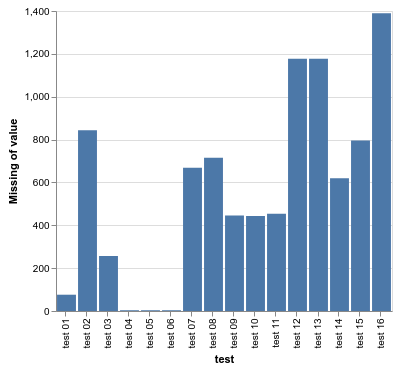

In [10]:
alt.Chart(df_wide.melt(id_vars=["dataset", "participant", "muscle"])).mark_bar().encode(
    x="test", y="missing(value)"
)

## Which test normalizes which muscle

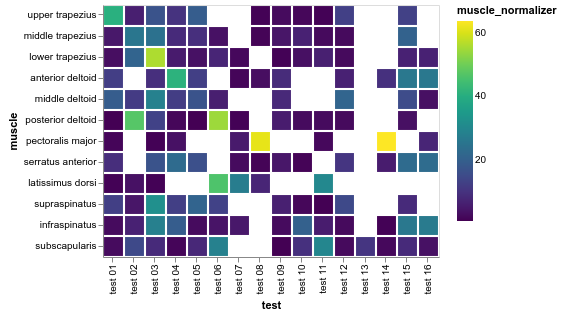

In [11]:
dff = df_tidy.groupby(["test", "muscle"])["mvc"].count().rename("count").to_frame()

max_test = (
    df_tidy.groupby(["participant", "muscle"], as_index=False)
    .apply(lambda x: x["test"][x["mvc"].idxmax()])
    .rename("test")
    .reset_index()
)

dff = dff.merge(
    max_test.groupby(["muscle", "test"]).count().reset_index(), on=["muscle", "test"]
).rename(columns={"participant": "max_test"})


dff["muscle_normalizer"] = dff["max_test"] / dff["count"] * 100

alt.Chart(dff).mark_rect().encode(
    x="test", y=alt.Y("muscle", sort=alt.Sort(MUSCLES)), color="muscle_normalizer"
)

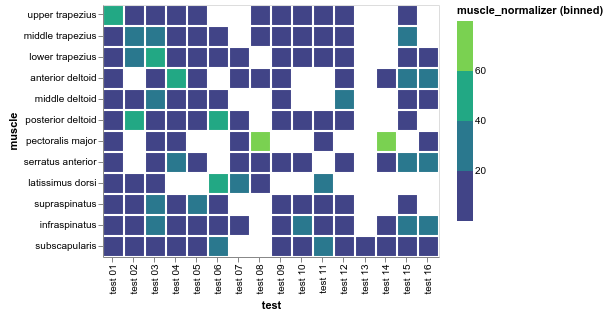

In [12]:
alt.Chart(dff).mark_rect().encode(
    x="test",
    y=alt.Y("muscle", sort=alt.Sort(MUSCLES)),
    color=alt.Color("muscle_normalizer", bin=True),
)

# Part 3: Machine learning pipeline

Since tests number 4, 5 and 6 have few missing data (3) and are good normalizers, we will try to predict the maximum obtained with the 16 tests from these three tests alone.

## Split the data

In [13]:
from sklearn.model_selection import GroupShuffleSplit


class Pipeline:
    def __init__(self):
        pass

    def get_X_and_y(self, d, cols):
        d = self.drop_na_rows(d, cols)
        X = d[cols].drop("muscle", axis=1)
        y = d.select_dtypes(include="float64").max(axis=1)
        p = d["participant"]
        return X, y, p

    @staticmethod
    def drop_na_rows(d, cols):
        c = [i for i in cols if i != "muscle"]
        original_shape = d.shape
        d = d.dropna(how="all", subset=c)
        deleted_rows = original_shape[0] - d.shape[0]
        if deleted_rows != 0:
            print(f'drop {deleted_rows} NaN rows')
        return d

    @staticmethod
    def split_data(X, y, p, test_size):
        # we want to make sure that all the data from one participant is in only one set
        train_id, test_id = next(
            GroupShuffleSplit(test_size=test_size, random_state=RANDOM_SEED).split(
                X, groups=p
            )
        )
        return X.iloc[train_id], X.iloc[test_id], y.iloc[train_id], y.iloc[test_id]


## Normalization

In [14]:
class Normalize:
    def __init__(self, ref):
        self.ref = ref

    def fit(self, X, y=None):
        self.ref_vector = X[self.ref]
        return self

    def transform(self, X):
        return X.multiply(100, axis=0).divide(self.ref_vector, axis=0)

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

    def inverse_transform(self, X):
        return X.divide(100, axis=0).multiply(self.ref_vector, axis=0)

## Evaluation

In [15]:
from sklearn.metrics import r2_score


class Evaluate:
    def __init__(self):
        pass

    @staticmethod
    def mape_vector(y_true, y_pred):
        return (np.abs((y_true - y_pred) / y_true)) * 100

    def mape(self, y_true, y_pred):
        return self.mape_vector(y_true, y_pred).mean()

    @staticmethod
    def rmse(y_true, y_pred):
        val = np.sqrt(((y_pred - y_true) ** 2).mean())
        return val

    def report(self, y_true, y_pred):
        d = {
            "rmse": self.rmse(y_true, y_pred),
            "mape": self.mape(y_true, y_pred),
            "r2": r2_score(y_true, y_pred),
        }
        return d


In [16]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

COLS_TO_KEEP = ["muscle", "test 04", "test 05", "test 06"]
TEST_SIZE = 0.2
base_params = {"n_jobs": 1, "silent": True, "random_state": RANDOM_SEED}
results = {"train": {}, "test": {}}
index, model, mape_vector = {}, {}, {}

for imuscle in MUSCLES:
    subset = df_wide[df_wide["muscle"] == imuscle]
    pipe = Pipeline()
    X, y, participants = pipe.get_X_and_y(d=subset, cols=COLS_TO_KEEP)
    X_train, X_test, y_train, y_test = pipe.split_data(
        X, y, participants, test_size=0.2
    )

    index[imuscle] = {"train": y_train.index, "test": y_test.index}

    norm_train = Normalize(ref="test 05").fit(X_train)
    X_train, y_train = (norm_train.transform(X_train), norm_train.transform(y_train))

    norm_test = Normalize(ref="test 05").fit(X_test)
    X_test, y_test = norm_test.transform(X_test), norm_test.transform(y_test)

    fit_params = {
        "eval_set": [(X_train, y_train), (X_test, y_test)],
        "early_stopping_rounds": 50,
        "eval_metric": "rmse",
        "verbose": None,
    }

    model = XGBRegressor(**base_params)
    model.fit(X_train, y_train, **fit_params)

    y_pred_train, y_pred_test = (model.predict(X_train), model.predict(X_test))
    results["train"][imuscle] = Evaluate().report(y_train, y_pred_train)
    results["test"][imuscle] = Evaluate().report(y_test, y_pred_test)
    mape_vector[imuscle] = Evaluate().mape_vector(y_test, y_pred_test)

drop 1 NaN rows
drop 1 NaN rows
drop 1 NaN rows


In [17]:
r = pd.DataFrame()
for isplit in ["train", "test"]:
    s = pd.DataFrame(results[isplit]).T.rename_axis("muscle").reset_index()
    s["split"] = isplit
    r = pd.concat([r, s])
print(f"mean for all muscles:\n{r.mean()}")

mean for all muscles:
mape     21.153828
r2        0.595195
rmse    499.815641
dtype: float64


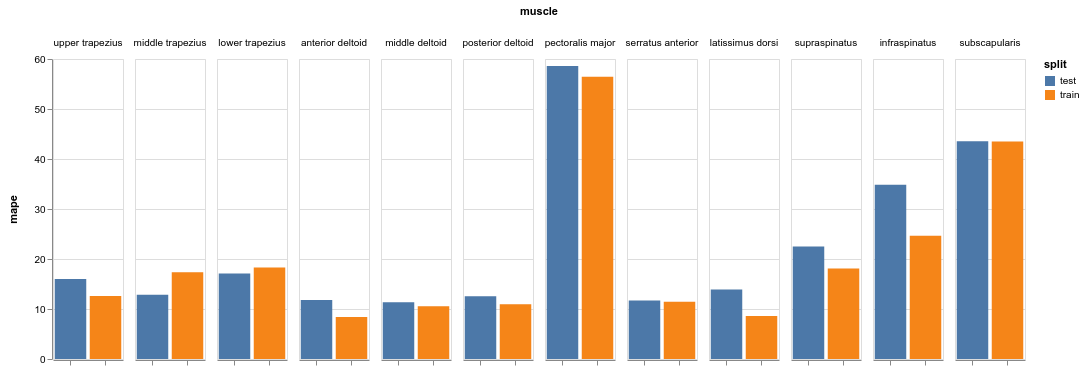

In [18]:
alt.Chart(r).mark_bar().encode(
    x=alt.X("split", axis=alt.Axis(title="", labels=False)),
    y="mape",
    color="split",
    column=alt.Column("muscle", sort=MUSCLES),
).properties(width=70)

# Part 4: Comparison with other studies

In [19]:
import pickle

RECOMMANDATIONS_PATH = MODEL_PATH / "recommandations.pkl"
if RECOMMANDATIONS_PATH.is_file():
    with open(RECOMMANDATIONS_PATH, "rb") as h:
        recommandations = pickle.load(h)
else:
    recommandations = {}


## Boettcher et al., 2008

[Boettcher et al., 2008](https://onlinelibrary.wiley.com/doi/abs/10.1002/jor.20675) identified a unique combinations of 4 MVIC tests to normalize 12 shoulder muscles

In [20]:
if not RECOMMANDATIONS_PATH.is_file():
    recommandations["nt4"] = {
        i: ["test 12", "test 13", "test 14", "test 15"] for i in MUSCLES
    }

## Dal Maso et al., 2016

[Dal Maso et al., 2016](https://www.sciencedirect.com/science/article/pii/S0003999316000307)

### As published

In [21]:
if not RECOMMANDATIONS_PATH.is_file():
    recommandations["dalmaso"] = {
        "upper trapezius": ["test 01", "test 03", "test 05", "test 12"],
        "middle trapezius": [
            "test 02",
            "test 03",
            "test 08",
            "test 10",
            "test 12",
            "test 15",
        ],
        "lower trapezius": ["test 02", "test 03", "test 05", "test 11", "test 15"],
        "anterior deltoid": ["test 04", "test 05", "test 09", "test 12"],
        "middle deltoid": ["test 03", "test 09", "test 12", "test 15"],
        "posterior deltoid": ["test 02", "test 06"],
        "pectoralis major": ["test 08", "test 14"],
        "serratus anterior": ["test 03", "test 05", "test 07", "test 14", "test 15"],
        "latissimus dorsi": ["test 06", "test 07", "test 08", "test 11"],
        "supraspinatus": ["test 01", "test 03", "test 05", "test 12"],
        "infraspinatus": ["test 02", "test 03", "test 04", "test 15"],
        "subscapularis": [
            "test 02",
            "test 03",
            "test 06",
            "test 10",
            "test 11",
            "test 15",
        ],
    }


### Implemented on our data

In [22]:
def compute_criterion(d, sets, thr):
    proportion = np.ones((sets.shape[0]))
    for i, iset in enumerate(sets):
        maximal_above_thr = d[iset].max(axis=1) > d.max(axis=1) * (thr / 100)
        proportion[i] = maximal_above_thr.sum() / d.shape[0] * 100

    sorted_idx = np.argsort(proportion)
    best_set = sets[sorted_idx][-1]
    best_proportion = proportion[sorted_idx][-1]
    return best_set, best_proportion


In [23]:
from itertools import combinations

THRESHOLD = 90
PERCENTILE = 90
TESTS = [i for i in df_wide.columns if i[:4] == "test"]

if RECOMMANDATIONS_PATH.is_file():
    print(recommandations["dalmaso_updated"])
else:
    recommandations["dalmaso_updated"] = {}
    for imuscle in MUSCLES:
        X_train = df_wide.loc[index[imuscle]["train"]][TESTS]
        print(f"{imuscle.upper()} ({X_train.shape[0]} points)")

        for ntests in range(1, len(TESTS) + 1):
            sets = np.array(list(combinations(TESTS, ntests)))
            best_set, best_proportion = compute_criterion(X_train, sets, thr=THRESHOLD)

            if best_proportion > PERCENTILE:
                print(f"\tno. of tests: {ntests}")
                print(f"\tbest set: {best_set}")
                print(f"\tproportion: {best_proportion:.2f}")
                print("-" * 10)
                recommandations["dalmaso_updated"][imuscle] = best_set
                break
    with open(RECOMMANDATIONS_PATH, "wb") as h:
        pickle.dump(recommandations, h)


{'upper trapezius': array(['test 01', 'test 03', 'test 05'], dtype='<U7'), 'middle trapezius': array(['test 02', 'test 03', 'test 05', 'test 09', 'test 10', 'test 15'],
      dtype='<U7'), 'lower trapezius': array(['test 02', 'test 03', 'test 04', 'test 06', 'test 15'], dtype='<U7'), 'anterior deltoid': array(['test 03', 'test 04', 'test 05', 'test 09', 'test 15', 'test 16'],
      dtype='<U7'), 'middle deltoid': array(['test 01', 'test 03', 'test 04', 'test 05', 'test 15'], dtype='<U7'), 'posterior deltoid': array(['test 02', 'test 03', 'test 06'], dtype='<U7'), 'pectoralis major': array(['test 08', 'test 14'], dtype='<U7'), 'serratus anterior': array(['test 01', 'test 03', 'test 04', 'test 05', 'test 15'], dtype='<U7'), 'latissimus dorsi': array(['test 06', 'test 07', 'test 11'], dtype='<U7'), 'supraspinatus': array(['test 01', 'test 03', 'test 04', 'test 05', 'test 09'], dtype='<U7'), 'infraspinatus': array(['test 03', 'test 04', 'test 06', 'test 10', 'test 11', 'test 15'],
      dt

## Compare Boettcher & Dal Maso with our model

### MAPE for each method

In [24]:
methods = ["nt4", "dalmaso", "dalmaso_updated", "ml3"]
comp = pd.DataFrame()

for imuscle in MUSCLES:
    current = df_wide.loc[index[imuscle]["test"]][TESTS]
    for imethod in methods:

        if imethod == "ml3":
            current_error = mape_vector[imuscle]
        else:
            current_error = Evaluate().mape_vector(
                current.max(axis=1),
                current[recommandations[imethod][imuscle]].max(axis=1),
            )
        s = pd.DataFrame(current_error, columns=["mape"])
        s["muscle"] = imuscle
        s["method"] = imethod
        comp = pd.concat([comp, s])


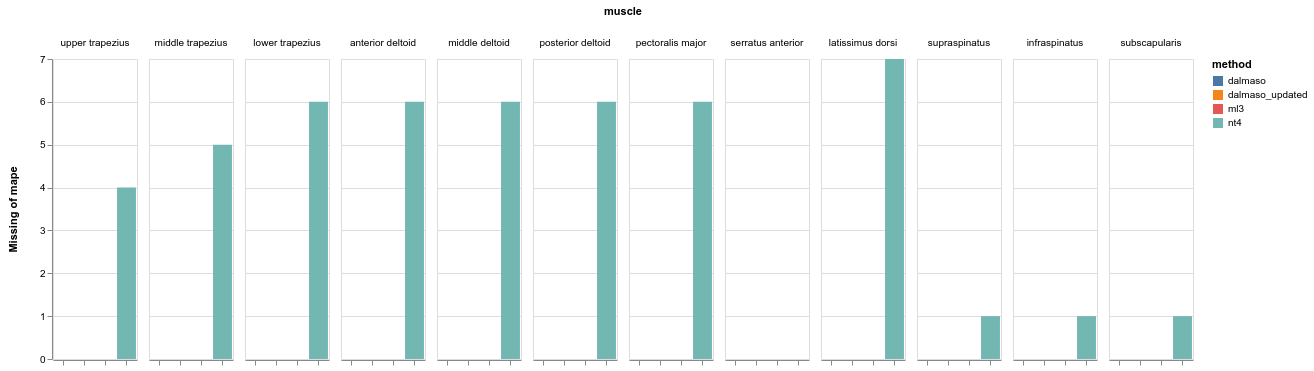

In [25]:
alt.Chart(comp).mark_bar().encode(
    x=alt.X("method", axis=alt.Axis(title="", labels=False)),
    y="missing(mape)",
    color="method",
    column=alt.Column("muscle", sort=MUSCLES),
)

### Non-parametric T-tests

In [26]:
from sklearn.impute import SimpleImputer
import spm1d
import warnings

warnings.simplefilter("ignore", RuntimeWarning)

ALPHA = 0.05
N_ITER = 10000
p_value = {}

for imethod in combinations(set(methods), 2):
    print(f"{imethod[0].upper()} vs. {imethod[1].upper()}")
    p_value[imethod] = {}
    for imuscle in MUSCLES:

        a = comp.query(f'muscle == "{imuscle}" & method == "{imethod[0]}"')[
            "mape"
        ].values.reshape(-1, 1)
        b = comp.query(f'muscle == "{imuscle}" & method == "{imethod[1]}"')[
            "mape"
        ].values.reshape(-1, 1)

        a = SimpleImputer(strategy="median").fit_transform(a)
        c = SimpleImputer(strategy="median").fit_transform(b)

        ttest = spm1d.stats.nonparam.ttest_paired(a.ravel(), b.ravel())
        ttesti = ttest.inference(alpha=ALPHA, iterations=N_ITER, two_tailed=True)

        if ttesti.h0reject:
            direction = ">" if a.mean() > b.mean() else "<"
            string = f"{imethod[0]} {direction} {imethod[1]}"
            p_value[imethod][imuscle] = ttesti.p
        else:
            string = "no differences"
            p_value[imethod][imuscle] = np.nan

        print(f"\t{imuscle}: {string}")

ML3 vs. DALMASO
	upper trapezius: ml3 > dalmaso
	middle trapezius: ml3 > dalmaso
	lower trapezius: ml3 > dalmaso
	anterior deltoid: no differences
	middle deltoid: no differences
	posterior deltoid: no differences
	pectoralis major: ml3 > dalmaso
	serratus anterior: no differences
	latissimus dorsi: ml3 > dalmaso
	supraspinatus: ml3 > dalmaso
	infraspinatus: ml3 > dalmaso
	subscapularis: ml3 > dalmaso
ML3 vs. NT4
	upper trapezius: no differences
	middle trapezius: no differences
	lower trapezius: no differences
	anterior deltoid: no differences
	middle deltoid: no differences
	posterior deltoid: no differences
	pectoralis major: no differences
	serratus anterior: no differences
	latissimus dorsi: no differences
	supraspinatus: no differences
	infraspinatus: no differences
	subscapularis: no differences
ML3 vs. DALMASO_UPDATED
	upper trapezius: ml3 > dalmaso_updated
	middle trapezius: ml3 > dalmaso_updated
	lower trapezius: ml3 > dalmaso_updated
	anterior deltoid: ml3 > dalmaso_updated


In [27]:
p = pd.DataFrame(p_value).T.reset_index()
p = (
    p.set_index(p["level_0"] + " vs " + p["level_1"])
    .drop(["level_0", "level_1"], axis=1)
    .T
)
p

,ml3 vs dalmaso,ml3 vs nt4,ml3 vs dalmaso_updated,dalmaso vs nt4,dalmaso vs dalmaso_updated,nt4 vs dalmaso_updated
anterior deltoid,NaN,NaN,0.0001,NaN,NaN,0.0001
infraspinatus,0.0060,NaN,0.0001,NaN,NaN,0.0001
latissimus dorsi,0.0001,NaN,0.0001,NaN,NaN,0.0001
lower trapezius,0.0058,NaN,0.0001,NaN,NaN,0.0001
middle deltoid,NaN,NaN,0.0020,NaN,0.0158,0.0001
middle trapezius,0.0030,NaN,0.0001,NaN,NaN,0.0001
pectoralis major,0.0001,NaN,0.0001,NaN,NaN,NaN
posterior deltoid,NaN,NaN,0.0001,NaN,NaN,0.0001
serratus anterior,NaN,NaN,0.0002,0.0001,NaN,0.0002
subscapularis,0.0002,NaN,0.0001,NaN,NaN,0.0001


In [28]:
pd.cut(
    p.stack(),
    bins=[-np.inf, 0.0001, 0.001, 0.01, 0.05, np.inf],
    labels=["****", "***", "**", "*", "ns"],
).unstack()

,ml3 vs dalmaso_updated,nt4 vs dalmaso_updated,ml3 vs dalmaso,dalmaso vs dalmaso_updated,dalmaso vs nt4
anterior deltoid,****,****,NaN,NaN,NaN
infraspinatus,****,****,**,NaN,NaN
latissimus dorsi,****,****,****,NaN,NaN
lower trapezius,****,****,**,NaN,NaN
middle deltoid,**,****,NaN,*,NaN
middle trapezius,****,****,**,NaN,NaN
pectoralis major,****,NaN,****,NaN,NaN
posterior deltoid,****,****,NaN,NaN,NaN
serratus anterior,***,***,NaN,NaN,****
subscapularis,****,****,***,NaN,NaN


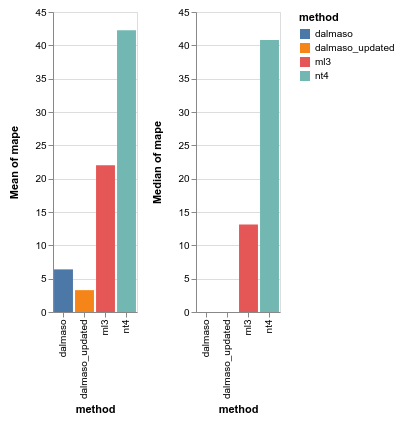

In [66]:
m_mean = alt.Chart(comp).mark_bar().encode(x="method", y="mean(mape)", color="method")
m_median = alt.Chart(comp).mark_bar().encode(x="method", y="median(mape)", color="method")

m_mean | m_median

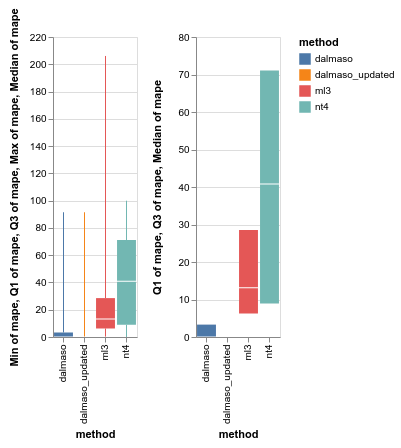

In [46]:
# Define aggregate fields
lower_box = "q1(mape)"
lower_whisker = "min(mape)"
upper_box = "q3(mape)"
upper_whisker = "max(mape)"

base = alt.Chart(comp).encode(x="method", color="method")

lower_plot = base.mark_rule().encode(y=lower_whisker, y2=lower_box)

middle_plot = base.mark_bar().encode(y=lower_box, y2=upper_box)

upper_plot = base.mark_rule().encode(y=upper_whisker, y2=upper_box)


middle_tick = (
    alt.Chart(comp)
    .mark_tick(color="white", size=20)
    .encode(y="median(mape)", x="method")
)

(lower_plot + middle_plot + upper_plot + middle_tick) | (middle_plot + middle_tick)

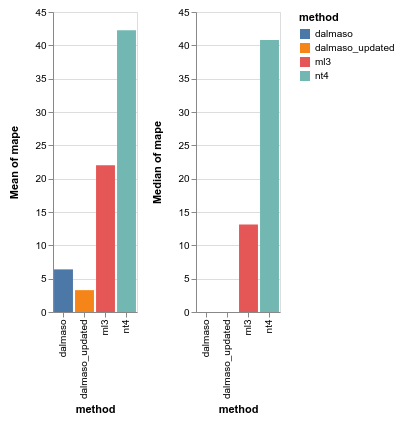

In [62]:
m_mean = alt.Chart(comp).mark_bar().encode(x="method", y="mean(mape)", color="method")
m_median = alt.Chart(comp).mark_bar().encode(x="method", y="median(mape)", color="method")

m_mean | m_median

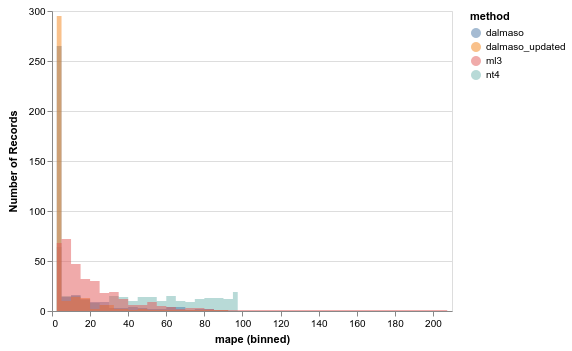

In [31]:
alt.Chart(comp).mark_area(opacity=0.5, interpolate="step").encode(
    alt.X("mape", bin=alt.Bin(maxbins=100)),
    alt.Y("count()", stack=None),
    alt.Color("method"),
)

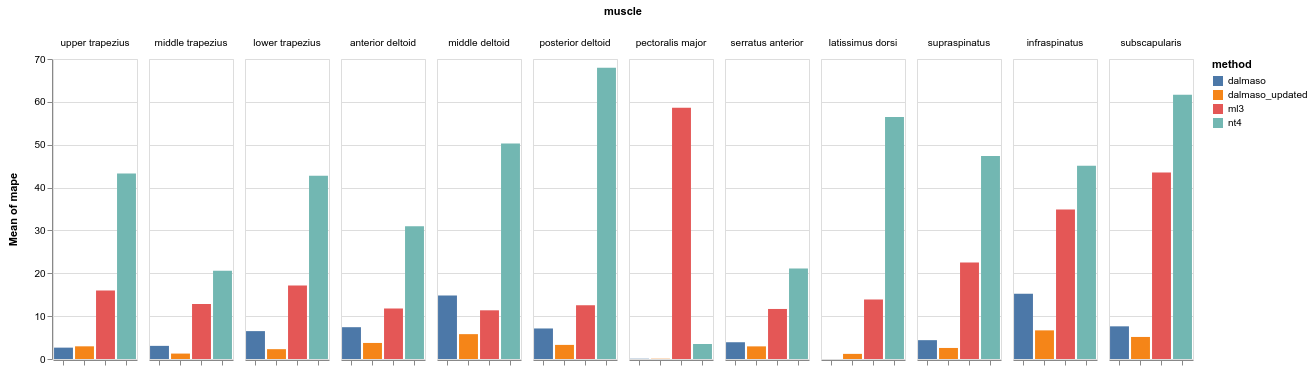

In [58]:
alt.Chart(comp).mark_bar().encode(
    x=alt.X("method", axis=alt.Axis(title="", labels=False)), y="mean(mape)", color="method"
).facet(column=alt.Column("muscle", sort=MUSCLES))

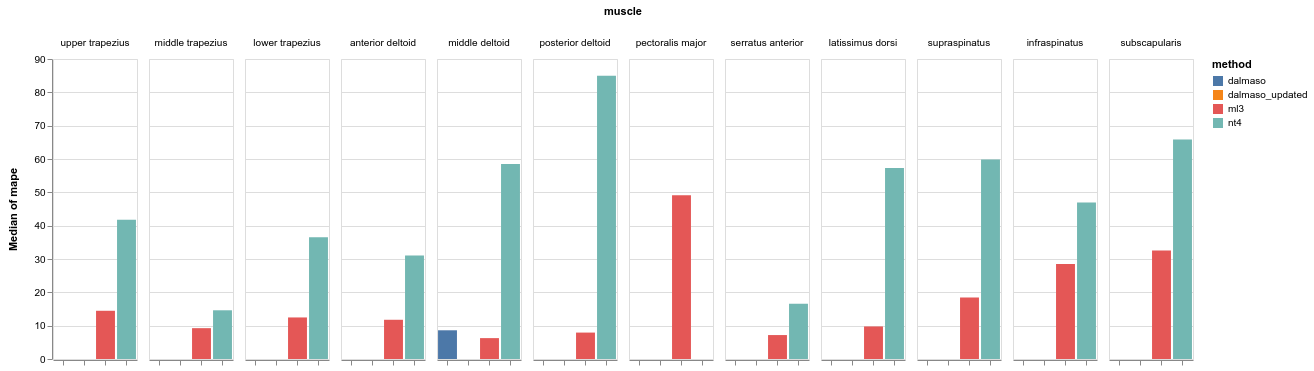

In [59]:
alt.Chart(comp).mark_bar().encode(
    x=alt.X("method", axis=alt.Axis(title="", labels=False)), y="median(mape)", color="method"
).facet(column=alt.Column("muscle", sort=MUSCLES))